# What's Cooking?

#### before we start with the problem itself there are some questions we need to answer:
1. What is the business question?
2. What each row represent?
3. What is the evaluation method?

#### for this problem (and all kaggle problems) the answers to these questions is always in the problem's overview page.
1. What is the category of a dish's cuisine given a list of its ingredients? (Supervised ML Problem)
2. Each row represent a recipe.
3. Submissions are evaluated on the categorization accuracy (the percent of dishes that you correctly classify).

# 1. Important imports
### let's start by importing needed libraries.

In [3]:
# load data libraries
import numpy as np # linear algebra library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile # to read zip files
from sklearn.model_selection import train_test_split


# data understanding libraries
import matplotlib.pyplot as plt # ploting library
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter


# data preparation
import re
# from nltk.stem import PorterStemmer


# ADS Creation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

# Evaluation and Model Selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [4]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision',150)
pd.options.display.float_format = '{:,.3f}'.format

# 2. Load Data
### Let's load the data and have a look on it.
1. data is provieded in a zip file, so we need to unzip it first using zipfile library.
2. the traning/ testing files available in json file format, to read it we use pd.read_json function.
        we read the data into pandas dataframes which is a 2-dimensional labeled data structure with columns of
        potentially different types. You can think of it like a spreadsheet or SQL table.
3. to view some rows of the dataframe we use df_name.head() method which output the first 5 rows of the dataframe.

In [8]:
#unzip the files
archive_train = zipfile.ZipFile('train.json.zip')

#read training json file 
train = pd.read_json(archive_train.read('train.json'))

#output the frist 5 rows
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


> There are only 3 columns: id, cuisine and ingredients

In [9]:
train_data, test_data = train_test_split(train, test_size=0.4, random_state=1)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=1)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [10]:
print("Train set size is ",len(train_data))
print("Val set size is ",len(val_data))
print("Test set size is ",len(test_data))

Train set size is  23864
Val set size is  7955
Test set size is  7955


# 2. Data Understanding
### The first and most important step in any ML project is understanding the data, so let's try to do this together.
## 2.1 What is the structure of the data?
        - df.info() return the main info about the dataframe

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23864 entries, 0 to 23863
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           23864 non-null  int64 
 1   cuisine      23864 non-null  object
 2   ingredients  23864 non-null  object
dtypes: int64(1), object(2)
memory usage: 559.4+ KB


> The main takeaways are: 
> - There is 23864 records.
> - There is no nulls in all columns.
> - only the id in an integer column.

## 2.2 How many cuisines are there?
        - df[col].unique() method which returns list of unique values in the selected column.
        - len(list) function which is simply output the len of any given list.

In [12]:
# number of unique cuisines
num_cuisines = len(train_data['cuisine'].unique())
print("there are ",num_cuisines," unique cuisines.")

there are  20  unique cuisines.


## 2.3 What is the frequency of each cuisine?
        - df[col].value_counts() returns number of rows for each unique value in the given column.

In [13]:
# let's save list of cuisine names we have
labels = train_data['cuisine'].unique()

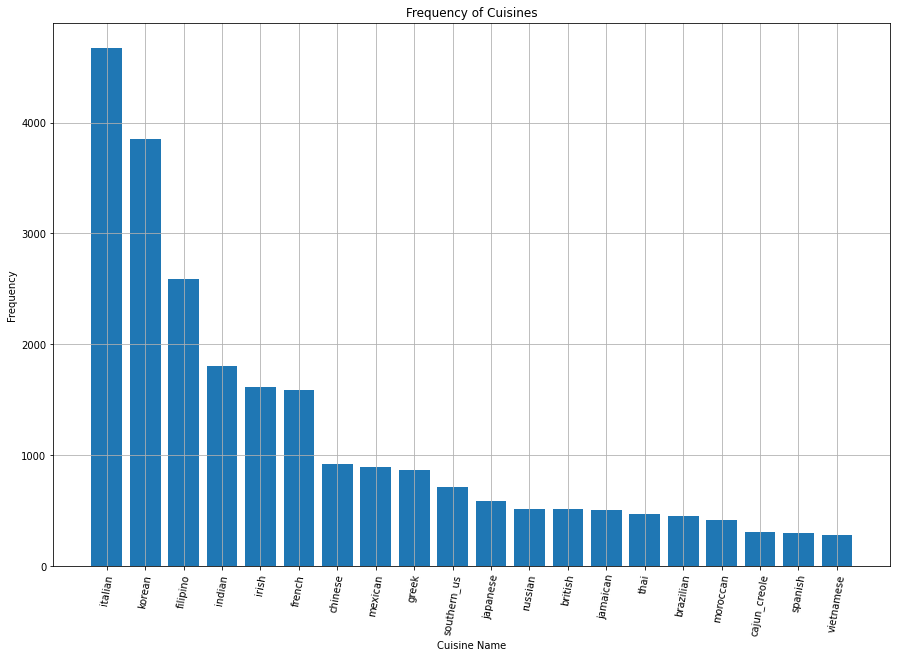

In [14]:
# plot the graph
fig, ax = plt.subplots(figsize=(15,10)) # create the plot and specify the figure size
plt.xlabel('Cuisine Name') # specify the x labels
plt.ylabel('Frequency') # specify the y labels
plt.title('Frequency of Cuisines') # specify the plot title
plt.bar(labels,train_data['cuisine'].value_counts()) # create a bar plot
plt.xticks(rotation=80) # rotate the x labels
plt.grid() # show the grid
plt.show() # show the final plot

>  So we have multiple outcome from this graph:
> - the data is skiwed (not balanced), more than half of the cuisines have 1k or less recipes.

## 2.4 How many ingredients per recipes we have?
        - df[col].apply(funtion) used to apply the given function to all rows of the given column without need to loop.
        - df.sort_index() sort the dataframe by it's label not it's value, there is another function df.sort_values() to do the opposite.

In [15]:
# add column with num of ingredienrs per recipe
train_data['ingredients_num'] = train_data["ingredients"].apply(len)

# save list of the unique numbers we have
numbers = train_data["ingredients"].apply(len).unique()

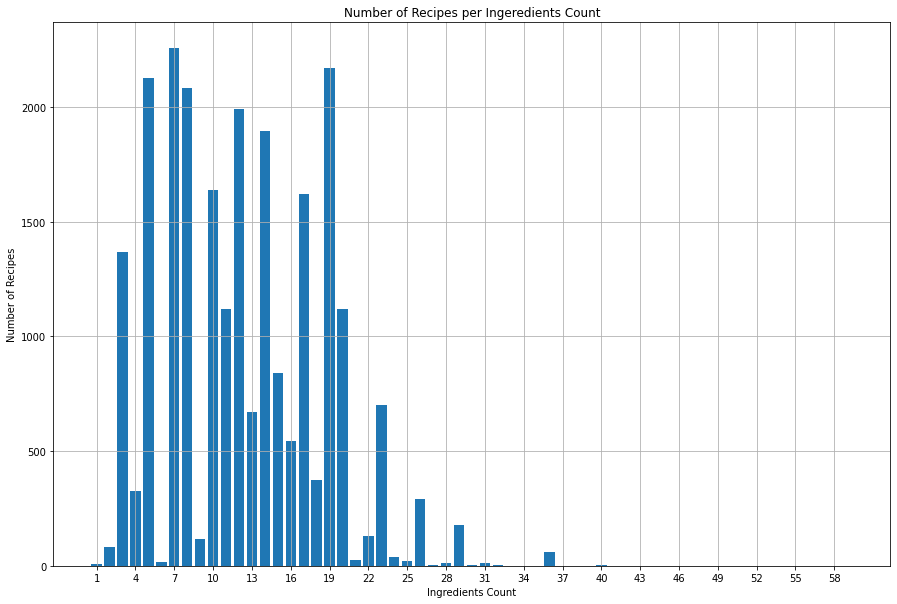

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
plt.bar(numbers,train_data["ingredients_num"].value_counts().sort_index())
plt.xlabel('Ingredients Count')
plt.ylabel('Number of Recipes')
plt.title('Number of Recipes per Ingeredients Count')
plt.xticks(np.arange(min(numbers), max(numbers)+1, 3.0)) # change x labels from the defult to the given range
plt.grid()
plt.show()

Let's try to view the graph in another way.

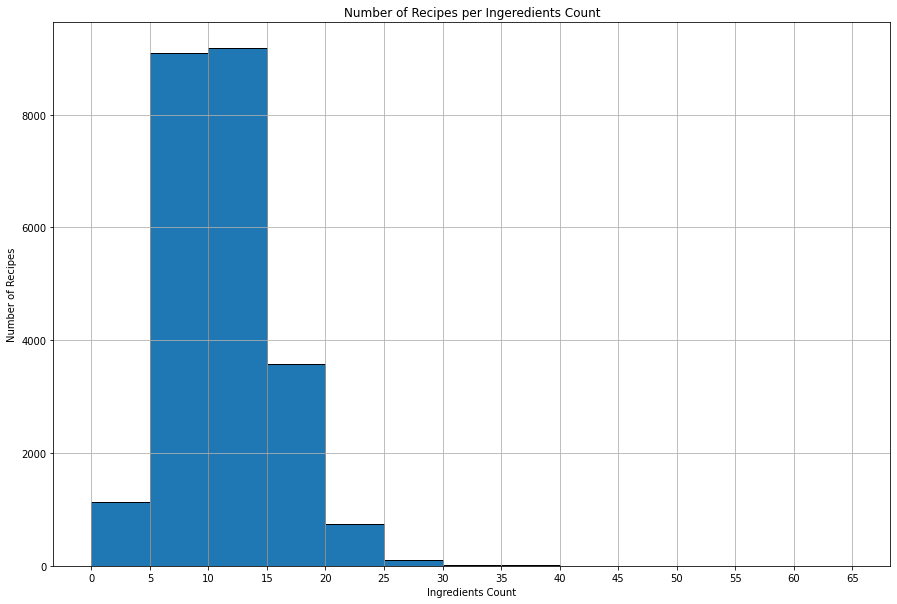

In [17]:
bins = range(0,70,5)

fig, ax = plt.subplots(figsize=(15,10))
plt.hist(train_data['ingredients_num'], bins=bins, edgecolor="k") # output a histogram plot
plt.xlabel('Ingredients Count')
plt.ylabel('Number of Recipes')
plt.title('Number of Recipes per Ingeredients Count')
plt.xticks(bins) # change x labels from the defult to the given range
plt.grid()
plt.show()

> Now this have a more obvious information. 
> The idea is not only about analysing the data, it's about how to best describe the data.

> The main takeaways are:
> - almost 17k out of the 23k recipe have between 5 to 15 ingredients. (~73% of the data)

Now, let's build up on this information.

In [18]:
print("There are " ,len(train_data[train_data["ingredients_num"]<2]), " recipes with ingredients less than 2.")
print("There are " ,len(train_data[train_data["ingredients_num"]>30]), " recipes with ingredients more than 30.")

There are  15  recipes with ingredients less than 2.
There are  22  recipes with ingredients more than 30.


In [19]:
train_data[train_data["ingredients_num"]<2][['ingredients']]

,ingredients
1088,[sticky rice]
1972,[sushi rice]
2025,[lemonade concentrate]
6255,[spanish chorizo]
10335,[butter]
10952,[water]
11028,[unsalted butter]
11809,[jasmine rice]
13431,[butter]
14606,[corn tortillas]


> I'll assume that these are not recipes.

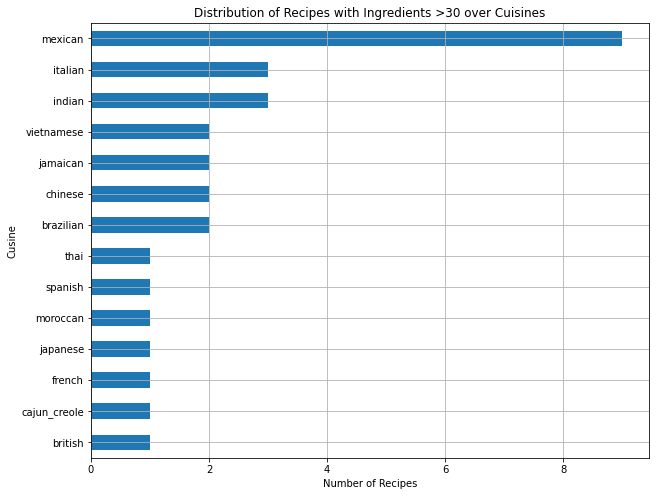

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
train_data[train_data["ingredients_num"]>=30].groupby(['cuisine']).size().sort_values().plot(kind='barh', ax=ax)
plt.title('Distribution of Recipes with Ingredients >30 over Cuisines')
plt.ylabel('Cusine')
plt.xlabel('Number of Recipes')
plt.grid()
plt.show()

> So almost half of the reciepies with large number of ingreadients are mexican.

## 2.5 What is the frequancy of the ingredients?

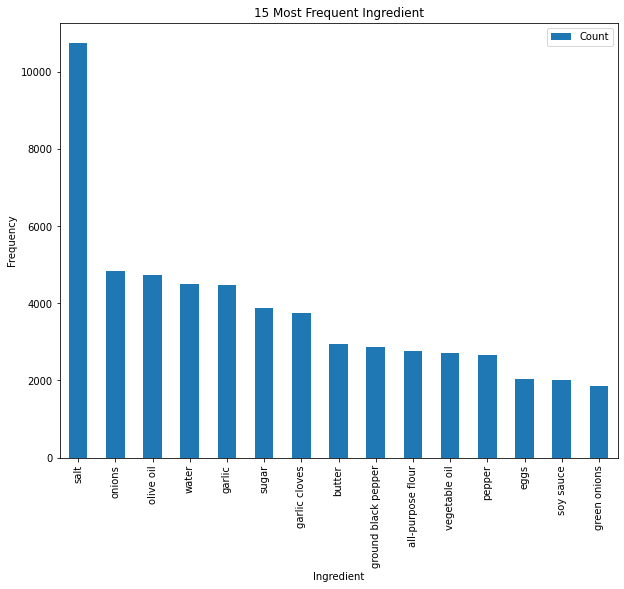

In [21]:
# now let's split all recipes ti have list of ingredients
ingredients = pd.Series((','.join([','.join(row["ingredients"]) for ind,row in train_data.iterrows()])).split(','))

fig, ax = plt.subplots(figsize=(10,8))
lst = Counter(ingredients).most_common(15)
df = pd.DataFrame(lst, columns = ['Ingredient', 'Count'])
df.plot.bar(x='Ingredient',y='Count', ax=ax)
plt.title('15 Most Frequent Ingredient')
plt.ylabel('Frequency')
plt.xlabel('Ingredient')
plt.show()

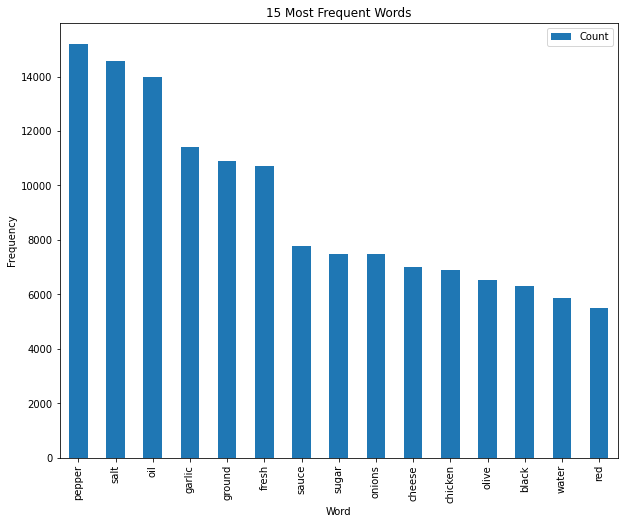

In [22]:
words = pd.Series(' '.join(ingredients).split())

fig, ax = plt.subplots(figsize=(10,8))
lst = Counter(words).most_common(15)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count', ax=ax)
plt.title('15 Most Frequent Words')
plt.ylabel('Frequency')
plt.xlabel('Word')
plt.show()

In [23]:
# words = pd.Series((' '.join([' '.join(row["ingredients"]) for ind,row in train_data.iterrows()])).split())
# recipies = pd.Series([' , '.join(row["ingredients"]) for ind,row in train_data.iterrows()])
# ingredients = pd.Series((' '.join([','.join(row["ingredients"]) for ind,row in train_data.iterrows()])).split(','))

let's see it in another way.

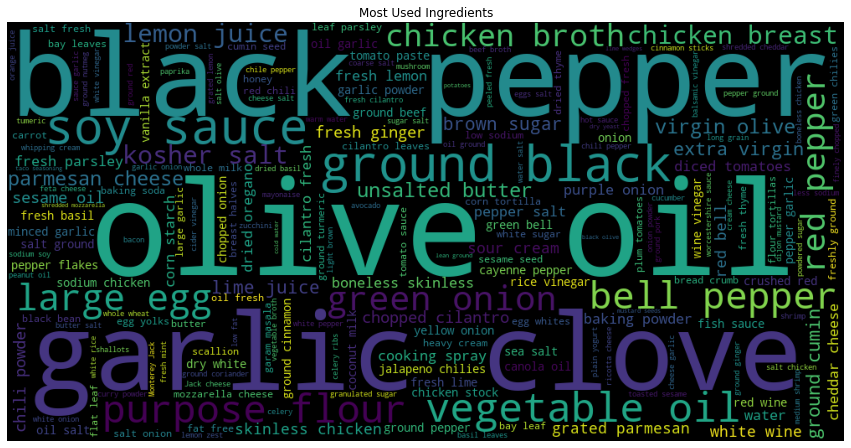

In [19]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Used Ingredients")
plt.axis("off")
plt.show()

The main takeaway from this graph is:
> tha most frequent ingredients are the assesstent mterials "like salt, pepper, oil,..."

Now, let's build up on this information.
## 2.5 What is the frequancy of the ingredients per cuisine?

In [40]:
counters = {}
for cuisine in train_data['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (train_data['cuisine'] == cuisine)
    for ingredients in train_data[indices]['ingredients']:
        counters[cuisine].update(ingredients)

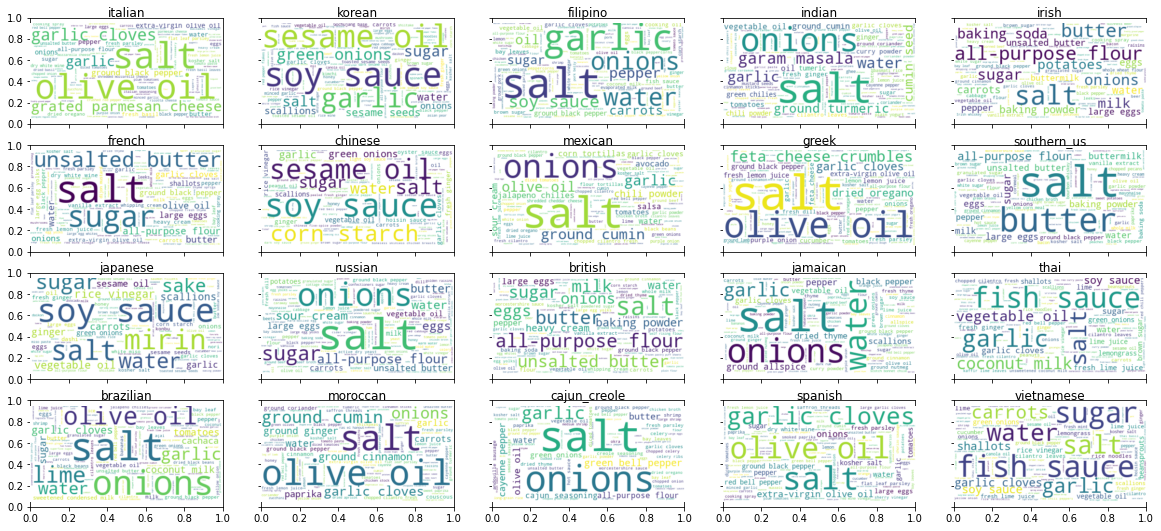

In [21]:
fig, axes = plt.subplots(4, 5, figsize=(20, 9),sharex='col', sharey='row')
for cuisine, ax_index in zip(counters, range(1,21)): 
    wordcloud = WordCloud(background_color="white")
    wordcloud.generate_from_frequencies(frequencies=counters[cuisine])
    fig.add_subplot(4, 5, ax_index)    
    plt.title(cuisine)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

Let's find some interesting takeaways:
> Salt is the most frequent ingredients in almost all the countries.

> for korea, chaina, japan the most frequent ingredient id the soy sauce.

> for thiland and vietnam the fish sauce.

## 2.5 What is the frequancy of the "top ingredients per cuisine" across the other cuisines?

In [38]:
train_data['ingredients_txt'] = pd.Series([' , '.join(row["ingredients"]) for ind,row in train_data.iterrows()])

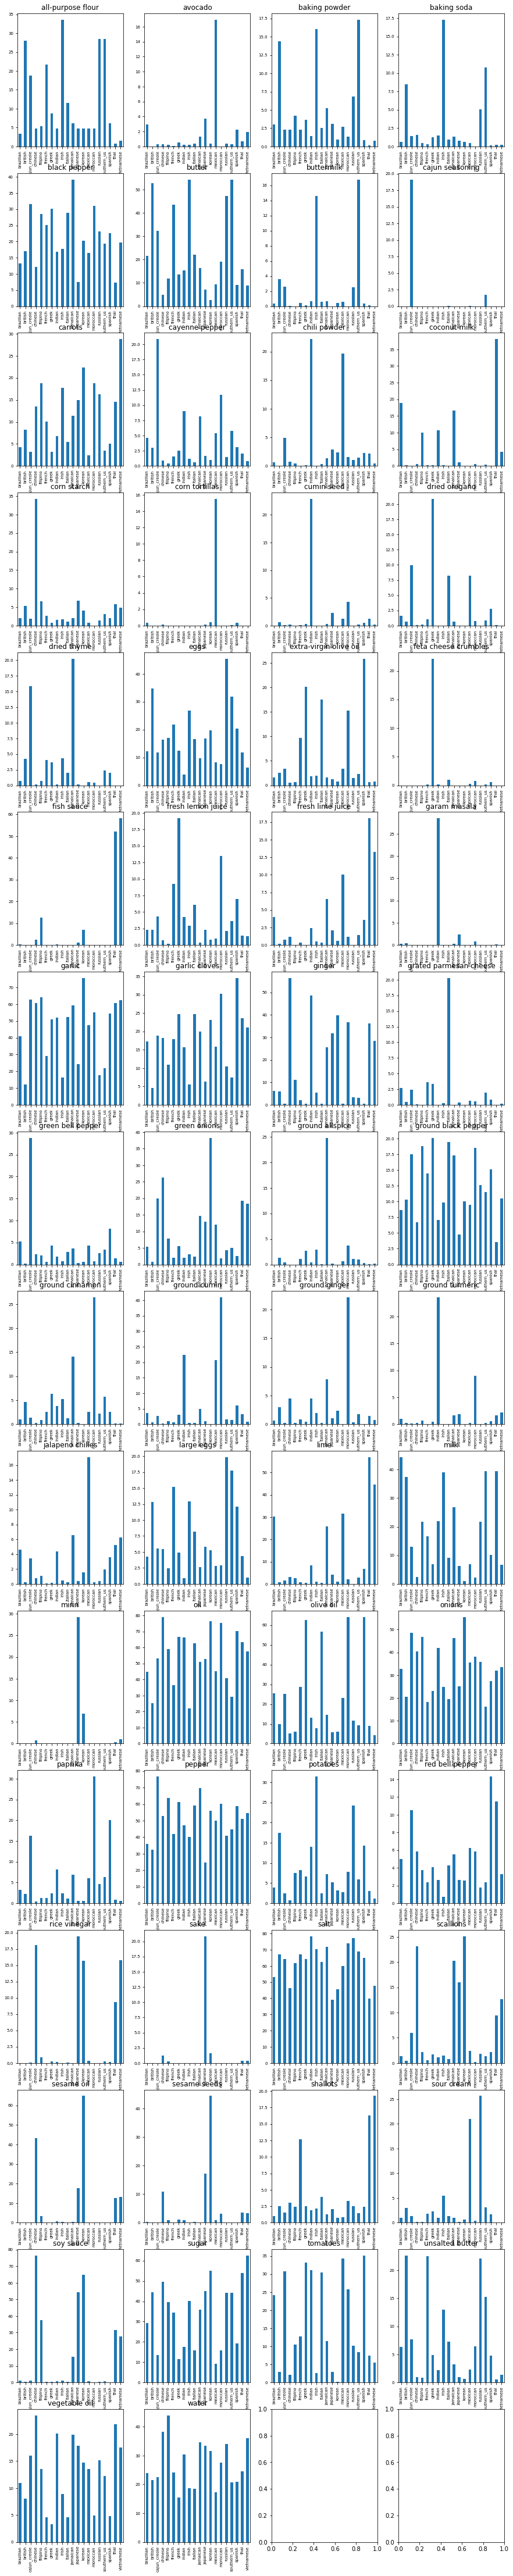

In [41]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])

unique = np.unique(top10.values.ravel())


fig, axes = plt.subplots(16, 4, figsize=(15, 80))
for ingredient, ax_index in zip(unique, range(64)):
    indices = train_data['ingredients_txt'].str.contains(ingredient)
    relative_freq = (train_data[indices]['cuisine'].value_counts() / train_data['cuisine'].value_counts())*100
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

Let's choose the unique ingeredients we want to focus on.

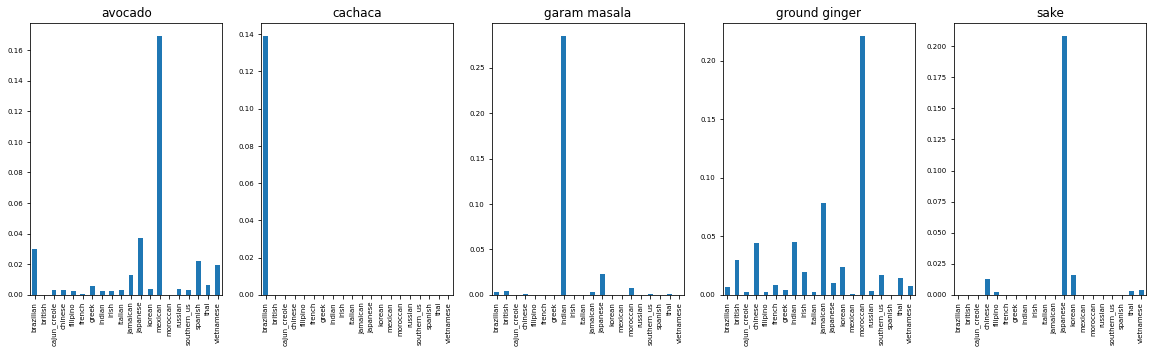

In [42]:
choosen = ['avocado', 'cachaca','garam masala', 'ground ginger','sake']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ingredient, ax_index in zip(choosen, range(5)):
    indices = train_data['ingredients_txt'].str.contains(ingredient)
    relative_freq = (train_data[indices]['cuisine'].value_counts() / train_data['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

so what are we seeing here?
> There are some ingredients that's points to some cuisines.

## 2.7 What is the correlation between cooking time and number of ingredients?

In [71]:
train_data["cooking_time"] = train_data["ingredients_num"] * np.random.randint(2,4, train_data.shape[0]) + np.random.randint(-15,15, train_data.shape[0])
train_data

,id,cuisine,ingredients,ingredients_num,cooking_time,ingredients_txt,contains_avocado
0,946,italian,"[water, white peaches, lemon juice, sugar, spa...",6,14,"water , white peaches , lemon juice , sugar , ...",False
1,36686,korean,"[carrot sticks, garlic, gochugaru, scallions, ...",9,24,"carrot sticks , garlic , gochugaru , scallions...",False
2,40125,italian,"[heavy cream, prosciutto, penne, parmigiano re...",4,4,"heavy cream , prosciutto , penne , parmigiano ...",False
3,28117,filipino,"[soy sauce, sesame oil, corn starch, ground pe...",13,21,"soy sauce , sesame oil , corn starch , ground ...",False
4,31933,italian,"[olive oil, garlic, italian seasoning, pepper,...",11,37,"olive oil , garlic , italian seasoning , peppe...",False
...,...,...,...,...,...,...,...
23859,46590,french,"[orange juice concentrate, garlic cloves, fres...",8,29,"orange juice concentrate , garlic cloves , fre...",False
23860,21032,italian,"[grated parmesan cheese, fresh basil leaves, e...",8,9,"grated parmesan cheese , fresh basil leaves , ...",False
23861,18844,italian,"[basil leaves, olive oil, extra-virgin olive o...",6,0,"basil leaves , olive oil , extra-virgin olive ...",False
23862,18202,russian,"[powdered sugar, large egg yolks, salt, heavy ...",15,33,"powdered sugar , large egg yolks , salt , heav...",False


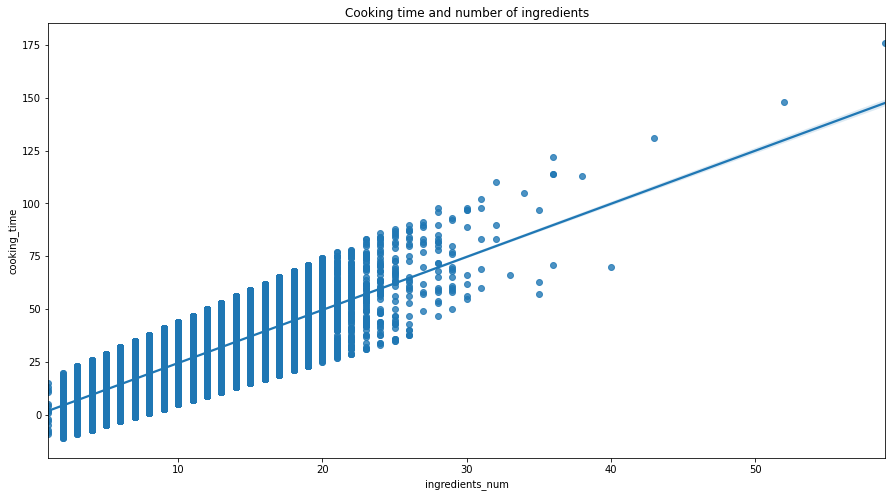

In [78]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.regplot(x=train_data["ingredients_num"] , y=train_data["cooking_time"] )
plt.title("Cooking time and number of ingredients")
plt.show()